In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from keras.utils import to_categorical

In [4]:
from keras.callbacks import EarlyStopping

In [5]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [6]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

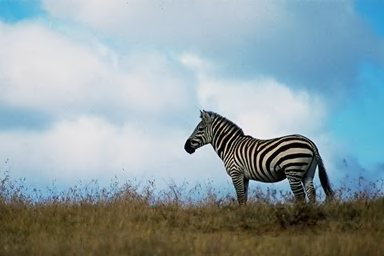

In [7]:
real_image_path = 'CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

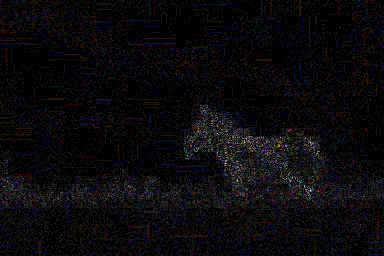

In [8]:
convert_to_ela_image(real_image_path, 91)

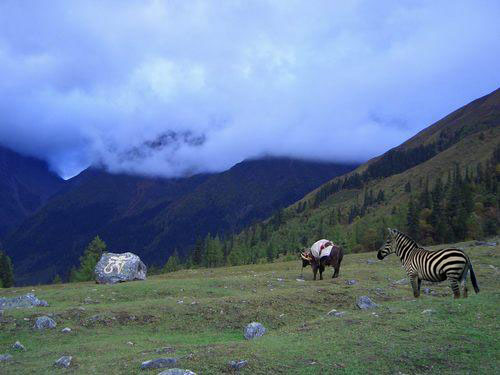

In [9]:
fake_image_path = 'CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

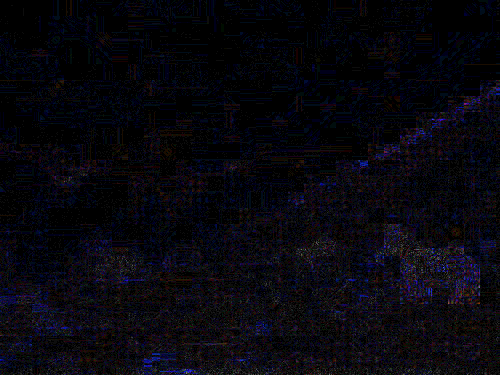

In [10]:
convert_to_ela_image(fake_image_path, 91)

In [13]:
image_size = (128, 128)

In [14]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 91).resize(image_size)).flatten() / 255.0

In [15]:
X = [] 
Y = [] 

In [16]:
import random
path = 'CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [17]:
path = 'CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))


Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [18]:
X = np.array(X)

In [19]:
Y = to_categorical(Y, 2)

In [20]:
X = X.reshape(-1, 128, 128, 3)

In [21]:

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))



3331 3331
833 833


In [22]:

def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model



In [23]:
model = build_model()
model.summary()

C:\Users\faroo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [25]:
epochs = 24
batch_size = 32

In [26]:

init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs)

C:\Users\faroo\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [27]:
from keras.callbacks import EarlyStopping
x_train2 = np.array(X_train, copy=True) 
y_train2 = np.array(Y_train, copy=True) 

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split = 0.2
    )

datagen.fit(X_train)

print(type(X_train))

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')

validation_generator = datagen.flow(x_train2, y_train2, batch_size=32, subset='validation')
train_generator = datagen.flow(x_train2, y_train2,batch_size=32, subset='training')


<class 'numpy.ndarray'>


In [28]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])


In [29]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 421ms/step - accuracy: 0.6638 - loss: 0.5666 - val_accuracy: 0.8908 - val_loss: 0.3297
Epoch 2/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 462ms/step - accuracy: 0.8822 - loss: 0.3441 - val_accuracy: 0.8932 - val_loss: 0.3013
Epoch 3/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 436ms/step - accuracy: 0.8947 - loss: 0.3102 - val_accuracy: 0.9100 - val_loss: 0.2574
Epoch 4/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 446ms/step - accuracy: 0.9149 - loss: 0.2624 - val_accuracy: 0.9208 - val_loss: 0.2229
Epoch 5/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 441ms/step - accuracy: 0.9201 - loss: 0.2342 - val_accuracy: 0.9220 - val_loss: 0.2080
Epoch 6/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 431ms/step - accuracy: 0.9201 - loss: 0.2076 - val_accuracy: 0.8932 - val_loss: 0.2712
Epoch 7/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 436ms/step - accuracy: 0.9101 - loss: 0.2133 - val_accuracy: 0.9340 - val_loss: 0.1719
Epoch 8/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 452ms/step - accuracy: 0.9336 - loss: 0

In [30]:
model.save('model_casia.h5')

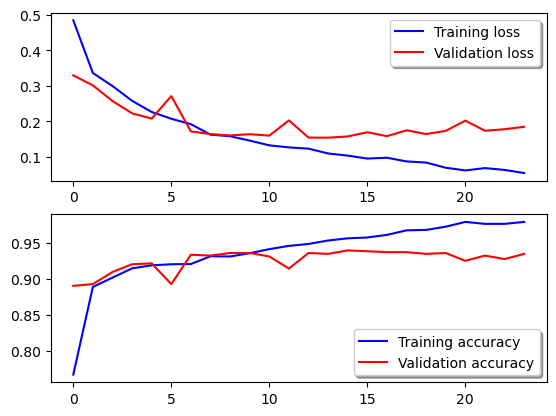

In [33]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


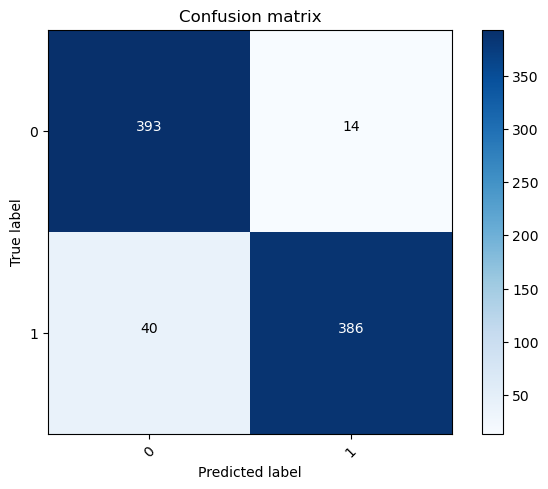

In [35]:
Y_pred = model.predict(X_val)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(2))